In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score,classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [4]:
# Para leer directamtente los datos
tf_idf = pd.read_csv("/home/andrea/Desktop/neotec/data/sentiment_analysis/tf_idf/labelled_tf_idf.csv")
tf_idf.drop('Unnamed: 0',inplace=True,axis = 1)
tf_idf.head(2)

,conversation_id,aa,abajo,abatido,abc,abdomen,abierto,aborrecido,abrazo,abril,...,zapato,zaragoz,zarza,zinquillo,zipi,zipperface,zona,zono,zorrilla,primary_label
0,0H9OEQs318oQ55Rn0SvK103578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
1,0H9OEQs318oQ55Rn0SvK913137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral


In [5]:
tf_idf["no"]

0       0.233594
1       0.000000
2       0.285368
3       0.166176
4       0.000000
          ...   
1305    0.000000
1306    0.000000
1307    0.000000
1308    0.000000
1309    0.077075
Name: no, Length: 1310, dtype: float64

In [6]:
# Create sets
X = tf_idf.drop(columns=["conversation_id","primary_label"], axis = 1)
y = tf_idf["primary_label"]

In [12]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

random_forest_results = pd.DataFrame()

parameters_column = []
score_column = []
cm_column = []
importances_column = []
auc_column = []

#for i in range(40):

# Divide data in training and test sets
X_tr_, X_tst_, y_train, y_test = train_test_split(X, y, test_size = 0.1)
#print(X_train.shape,X_test.shape)
#print(y_train.shape, y_test.shape)
d_ = X_tr_.shape[1]
k = round(d_*0.2)
feat_selector = SelectKBest(score_func=f_classif, k=k)
X_train = feat_selector.fit_transform(X_tr_, y_train)
X_test = feat_selector.transform(X_tst_)
print(f"Features retained: {X_tr_.shape[1]}")

# Validate parameters
model = RandomForestClassifier()
parameters_grid = { 
            'n_estimators': [200, 500],
            'max_depth' : np.arange(4, 40, 4),
        }
clf = GridSearchCV(model,parameters_grid,cv = 10, n_jobs = -1)
clf.fit(X_train, y_train)

# Best parameters
best_parameter = clf.best_params_ 
best_score = clf.best_score_ 
best_estimator = clf.best_estimator_

print(best_parameter)
parameters_column.append(best_parameter)
score_column.append(best_score)

# Create model with best parameters
best_estimator.fit(X_train,y_train)

# Prediction
y_pred = best_estimator.predict(X_test)

# AUC-ROC
r_probs=[0 for i in range(len(y_test))]
y_pred_prob = best_estimator.predict_proba(X_test)
mean_auc = roc_auc_score(y_test, y_pred_prob, average="weighted", multi_class='ovr')
print(mean_auc)
auc_column.append(mean_auc)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_column.append(cm)
print(cm)

# Get numerical feature importances
importances = best_estimator.feature_importances_
importances_column.append(importances)


random_forest_results["best_score"] = score_column
random_forest_results["best_parameters"] = parameters_column
random_forest_results["feature_importances"] = importances_column
random_forest_results["auc"] = auc_column
random_forest_results["test_confusion_matrix"] = cm_column

#random_forest_results.to_csv("/content/drive/MyDrive/sentiment_analysis/random_forest_results.csv")

Features retained: 3530


/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  21   39   88   93  107  123  132  133  134  218  224  233  238  268
  271  273  277  293  307  333  342  370  381  496  502  513  550  551
  571  572  600  625  631  703  811  850  857  892  895  953  968  973
 1122 1133 1164 1177 1198 1241 1258 1260 1262 1269 1291 1292 1298 1313
 1399 1400 1410 1447 1489 1497 1522 1531 1567 1571 1573 1599 1603 1605
 1623 1647 1687 1688 1694 1717 1761 1771 1793 1807 1830 1902 1919 1933
 1945 1975 1977 2016 2169 2182 2183 2196 2232 2233 2249 2268 2278 2284
 2318 2334 2352 2353 2374 2410 2414 2419 2423 2442 2469 2479 2485 2492
 2539 2553 2562 2625 2644 2652 2684 2686 2687 2696 2708 2775 2780 2787
 2791 2804 2811 2834 2855 2875 2911 2940 2944 2950 2953 2977 2986 2997
 3000 3003 3019 3036 3040 3072 3100 3106 3131 3134 3153 3177 3189 3191
 3214 3248 3260 3290 3334 3365 3372 3418 3432 3481 3519] are constant.
  warnings.warn("Features %s ar

{'max_depth': 32, 'n_estimators': 200}
0.7855435245730764
[[ 9 18  3]
 [ 6 43 12]
 [ 0 10 30]]


In [16]:
random_forest_results.head()

,best_score,best_parameters,feature_importances,auc,test_confusion_matrix
0,0.653064,"{'max_depth': 32, 'n_estimators': 200}","[0.00022321019078600776, 0.0012521877395776572...",0.785544,"[[9, 18, 3], [6, 43, 12], [0, 10, 30]]"


In [17]:
random_forest_results.to_csv("/content/drive/MyDrive/sentiment_analysis/random_forest_results.txt",float_format="%.6f")

<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encountered in long_scalars
  tpr =  TP/(TP + FN)
<ipython-input-15-748130bc418f>:16: RuntimeWarning: invalid value encoun

ValueError: ignored

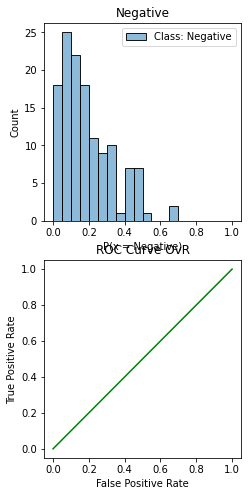

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

def calculate_tpr_fpr(y_real, y_pred):
    # Calculate confusion matrix and recover values
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculate tpr and fpr
    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN + FP)
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
  
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter=True, ax=None):
    if ax == None:
        plt.figure(figsize=(5, 5))
        ax = plt.axes()
    
    if scatter:
        sn.scatterplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=[0, 1], y=[0, 1], color='green', ax=ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = ["Negative", "Neutral", "Positive"] # list of label names
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_test)
    df_aux['class'] = [1 if y == i else 0 for y in y_test]
    df_aux['prob'] = y_pred_prob[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sn.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()


### Feature mean importances

In [ ]:
mean_importances  = np.mean(random_forest_results["feature_importances"],axis = 0)

In [ ]:
mean_importances

array([1.00353427e-03, 1.16653871e-05, 3.54910737e-05, ...,
       1.57905253e-05, 1.05332655e-04, 4.65066829e-05])

In [ ]:
feature_list = list(X.columns)
feature_mean_importances = [(feature, importance) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_mean_importances = sorted(feature_mean_importances, key = lambda x: x[1], reverse = False)

In [ ]:
feature_mean_importances

[('paquete', 0.0),
 ('conversacion', 0.0),
 ('artritis', 0.0),
 ('picor', 0.0),
 ('paliza', 7.230898876287447e-08),
 ('rato', 1.4818812907536266e-07),
 ('pene', 1.9062358720510663e-07),
 ('sufrir', 2.218813859720946e-07),
 ('exagerado', 2.97552943863284e-07),
 ('respecto', 3.4815103282377966e-07),
 ('soplar', 3.6278652463139395e-07),
 ('hombro', 3.7670710521543857e-07),
 ('nombrado', 4.2784329911919437e-07),
 ('largo', 5.241923918436732e-07),
 ('mental', 5.541291283155947e-07),
 ('defensa', 5.773285369331163e-07),
 ('sevilla', 6.446676437631146e-07),
 ('rico', 7.11105514283822e-07),
 ('sangre', 8.404511204631243e-07),
 ('pulso', 8.475125836295119e-07),
 ('ia', 8.738548700909517e-07),
 ('medico', 9.615397042072288e-07),
 ('resfriado', 9.913210116868821e-07),
 ('alexis', 1.0120157205688358e-06),
 ('hombre', 1.1689789242401926e-06),
 ('var', 1.2085262473808933e-06),
 ('temporada', 1.2266590629859387e-06),
 ('reve', 1.293004123821721e-06),
 ('trasladar', 1.3138794900990677e-06),
 ('variar'

In [ ]:
np.save("mean_importances_random_forest.npy",feature_mean_importances)

### Delete features and training model 

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from math import ceil

new_results = pd.DataFrame()

parameters_column = []
score_column = []
accuracy_column = []
precision_column = []
recall_column = []
importances_column = []
number_of_features = []

index = 0

for i in range(19):
    feature_mean_importances = np.load("mean_importances_random_forest.npy")
    feature_mean_importances = feature_mean_importances[index: ]
    number_of_features.append(index)
    #print(len(feature_mean_importances))
    index += 100
    feature_names = [feature[0] for feature in feature_mean_importances]
    print(len(feature_names))
    
    # Create sets
    X = tf_idf[feature_names]
    print(X.shape)
    y = tf_idf["primary_label"]

    # Divide data in training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    #print(X_train.shape,X_test.shape)
    #print(y_train.shape, y_test.shape)

    # Validate parameters
    model = RandomForestClassifier()
    parameters_grid = { 
                'n_estimators': [200, 500],
                'max_depth' : np.arange(4, 40, 4),
            }
    clf = GridSearchCV(model,parameters_grid,cv = 10, n_jobs = -1, return_train_score = True)
    clf.fit(X_train, y_train)

    # Best parameters
    best_parameter = clf.best_params_ 
    best_score = clf.best_score_ 
    best_estimator = clf.best_estimator_

    print(best_parameter)
    parameters_column.append(best_parameter)
    score_column.append(best_score)

    # Create model with best parameters
    best_estimator.fit(X_train,y_train)

    # Prediction
    y_pred = best_estimator.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='micro')
    recall = recall_score(y_test, y_pred,average='micro')
    print(accuracy,precision,recall)

    accuracy_column.append(accuracy)
    precision_column.append(precision)
    recall_column.append(recall)

    # Get numerical feature importances
    importances = best_estimator.feature_importances_
    importances_column.append(importances)

new_results["number_features"] = number_of_features
new_results["best_score"] = score_column
new_results["best_parameters"] = parameters_column
new_results["feature_importances"] = importances_column
new_results["test_accuracy"] = accuracy_column
new_results["test_micro_precision"] = precision_column
new_results["test_micro_recall"] = recall_column

1995
(384, 1995)
{'max_depth': 12, 'n_estimators': 500}
0.6666666666666666 0.6666666666666666 0.6666666666666666
1895
(384, 1895)
{'max_depth': 28, 'n_estimators': 200}
0.6666666666666666 0.6666666666666666 0.6666666666666666
1795
(384, 1795)
{'max_depth': 8, 'n_estimators': 500}
0.5641025641025641 0.5641025641025641 0.5641025641025641
1695
(384, 1695)
{'max_depth': 20, 'n_estimators': 200}
0.6666666666666666 0.6666666666666666 0.6666666666666666
1595
(384, 1595)
{'max_depth': 4, 'n_estimators': 200}
0.5897435897435898 0.5897435897435898 0.5897435897435898
1495
(384, 1495)
{'max_depth': 12, 'n_estimators': 500}
0.6923076923076923 0.6923076923076923 0.6923076923076923
1395
(384, 1395)
{'max_depth': 4, 'n_estimators': 200}
0.7692307692307693 0.7692307692307693 0.7692307692307693
1295
(384, 1295)
{'max_depth': 12, 'n_estimators': 200}
0.6410256410256411 0.6410256410256411 0.6410256410256411
1195
(384, 1195)
{'max_depth': 12, 'n_estimators': 200}
0.7435897435897436 0.7435897435897436 0.743

In [ ]:
display(new_results)

,number_features,best_score,best_parameters,feature_importances,test_accuracy,test_micro_precision,test_micro_recall
0,0,0.687479,"{'max_depth': 12, 'n_estimators': 500}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.99650698...",0.666667,0.666667,0.666667
1,100,0.690168,"{'max_depth': 28, 'n_estimators': 200}","[0.0, 7.2672614386018e-05, 0.0, 0.0, 0.0, 0.0,...",0.666667,0.666667,0.666667
2,200,0.698235,"{'max_depth': 8, 'n_estimators': 500}","[0.0, 0.0, 0.0, 0.0, 0.0, 2.088536726333364e-0...",0.564103,0.564103,0.564103
3,300,0.690252,"{'max_depth': 20, 'n_estimators': 200}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.652...",0.666667,0.666667,0.666667
4,400,0.701681,"{'max_depth': 4, 'n_estimators': 200}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00024889...",0.589744,0.589744,0.589744
5,500,0.690000,"{'max_depth': 12, 'n_estimators': 500}","[7.788246243606402e-05, 2.3611432811005814e-05...",0.692308,0.692308,0.692308
6,600,0.669580,"{'max_depth': 4, 'n_estimators': 200}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001284693982...",0.769231,0.769231,0.769231
7,700,0.690000,"{'max_depth': 12, 'n_estimators': 200}","[0.0, 5.484735539462227e-06, 0.0, 0.0, 5.32963...",0.641026,0.641026,0.641026
8,800,0.684538,"{'max_depth': 12, 'n_estimators': 200}","[5.99572910917072e-05, 0.00035005027504846325,...",0.743590,0.743590,0.743590
9,900,0.687227,"{'max_depth': 12, 'n_estimators': 200}","[5.009328010683507e-05, 0.0, 0.0, 0.0, 0.0, 0....",0.666667,0.666667,0.666667
